In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
from sklearn.model_selection import StratifiedKFold

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

In [2]:
%%time
n_features = 300
features = [f'f_{i}' for i in range(n_features)]
train = pd.read_pickle('../inputs/dataset/train.pkl')
train.head()

CPU times: user 67.6 ms, sys: 583 ms, total: 651 ms
Wall time: 650 ms


,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,-0.300781
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,-0.231079
2,6,0,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,...,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652,0.568848
3,7,0,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,...,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438,-1.064453
4,8,0,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,...,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793,-0.531738


In [3]:
investment_id = train.pop("investment_id")
_ = train.pop("time_id")
y = train.pop("target")

In [4]:
%%time
investment_ids = list(investment_id.unique())
investment_id_size = len(investment_ids) + 1
investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
investment_id_lookup_layer.adapt(pd.DataFrame({"investment_ids":investment_ids}))

2022-03-02 22:13:36.287485: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-02 22:13:37.336078: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37822 MB memory:  -> device: 1, name: A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2022-03-02 22:13:37.742909: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 663 ms, sys: 574 ms, total: 1.24 s
Wall time: 1.65 s


In [5]:
import tensorflow as tf
def preprocess(X, y):
    return X, y
def make_dataset(feature, investment_id, y, batch_size=1024, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(4096)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [6]:
def get_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse', metrics=['mse', "mae", "mape", rmse])
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        114560      integer_lookup[0][0]             
__________________________________________________________________________________________________
reshape (Reshape)               (None, 32)           0           embedding[0][0]                  
______________________________________________________________________________________________

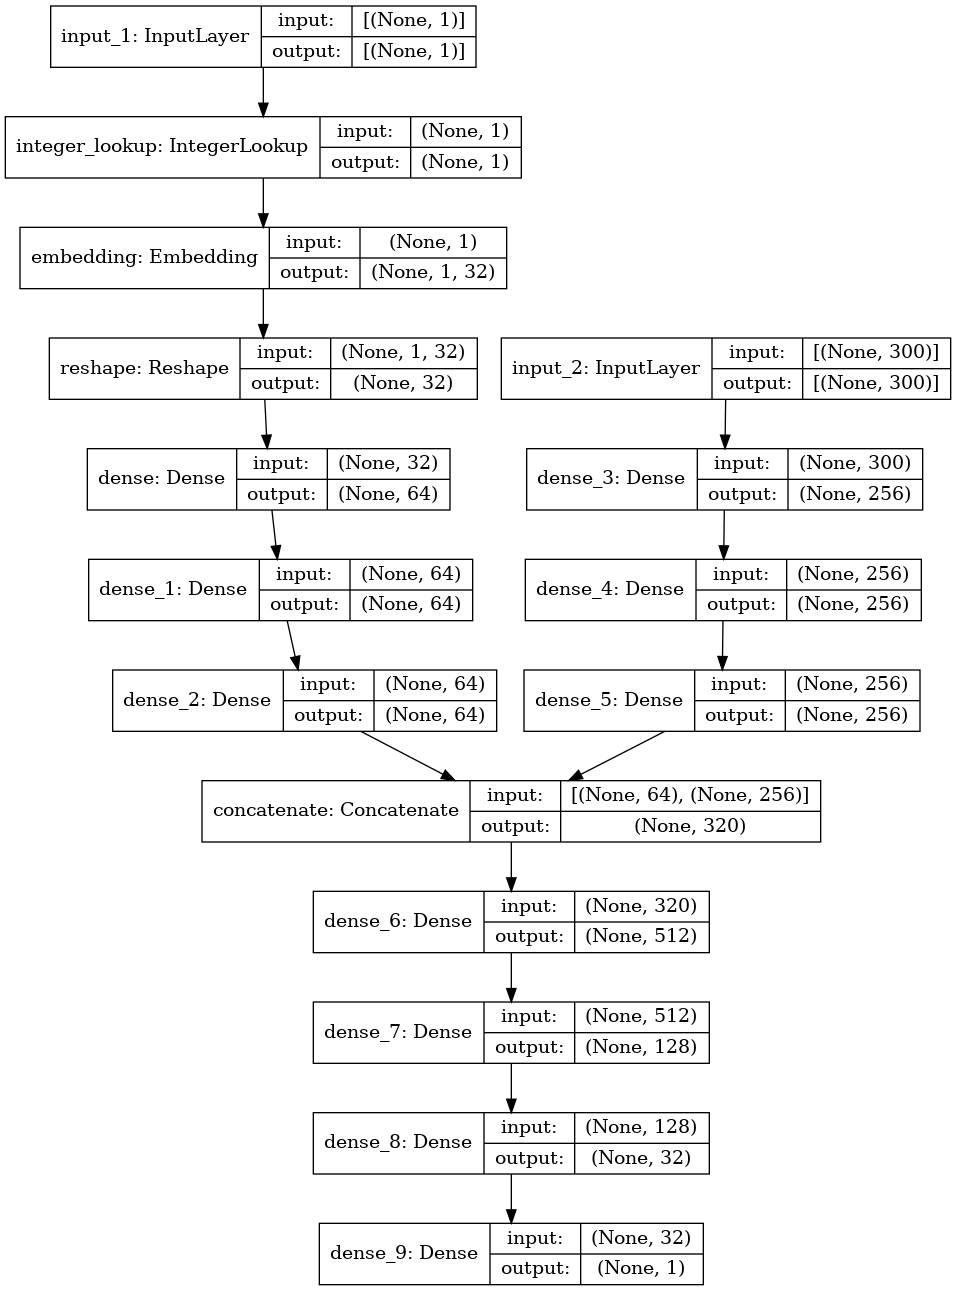

In [7]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

/opt/conda/envs/ubiquant/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Epoch 1/30
  44/2455 [..............................] - ETA: 8s - loss: 4.3024 - mse: 0.8718 - mae: 0.6436 - mape: 93402.0703 - rmse: 0.9337

2022-03-02 22:13:54.687304: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2455/2455 [==============================] - 13s 5ms/step - loss: 0.9107 - mse: 0.8312 - mae: 0.6244 - mape: 122696.3750 - rmse: 0.9117 - val_loss: 0.8401 - val_mse: 0.8387 - val_mae: 0.6281 - val_mape: 195356.1250 - val_rmse: 0.9158


2022-03-02 22:14:06.398632: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_0/assets
Epoch 2/30
2455/2455 [==============================] - 11s 4ms/step - loss: 0.8308 - mse: 0.8272 - mae: 0.6228 - mape: 148261.9844 - rmse: 0.9095 - val_loss: 0.8403 - val_mse: 0.8376 - val_mae: 0.6285 - val_mape: 185570.3906 - val_rmse: 0.9152
Epoch 3/30
2455/2455 [==============================] - 10s 4ms/step - loss: 0.8289 - mse: 0.8240 - mae: 0.6215 - mape: 151891.3281 - rmse: 0.9077 - val_loss: 0.8389 - val_mse: 0.8378 - val_mae: 0.6285 - val_mape: 200550.0312 - val_rmse: 0.9153
INFO:tensorflow:Assets written to: model_0/assets
Epoch 4/30
2455/2455 [==============================] - 11s 5ms/step - loss: 0.8280 - mse: 0.8213 - mae: 0.6204 - mape: 151525.4375 - rmse: 0.9063 - val_loss: 0.8403 - val_mse: 0.8379 - val_mae: 0.6296 - val_mape: 176979.5469 - val_rmse: 0.9154
Epoch 5/30
2455/2455 [==============================] - 11s 4ms/step - loss: 0.8261 - mse: 0.8196 - mae: 0.6201 - mape: 150960.8594 - rmse: 0.9053 - val_loss: 0.8387

Pearson: 0.11968249819649508


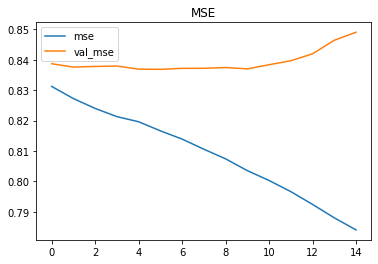

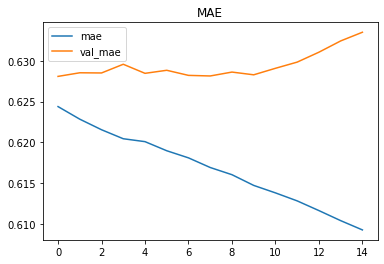

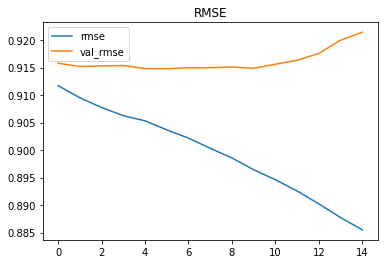

In [8]:
kfold = StratifiedKFold(5, shuffle=True, random_state=42)
models = []
for index, (train_indices, valid_indices) in enumerate(kfold.split(train, investment_id)):
    X_train, X_val = train.iloc[train_indices], train.iloc[valid_indices]
    investment_id_train = investment_id[train_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    investment_id_val = investment_id[valid_indices]
    train_ds = make_dataset(X_train, investment_id_train, y_train)
    valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
    model = get_model()
    checkpoint = keras.callbacks.ModelCheckpoint(f"model_{index}", save_best_only=True)
    early_stop = keras.callbacks.EarlyStopping(patience=10)
    history = model.fit(train_ds, epochs=30, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
    model = keras.models.load_model(f"model_{index}")
    models.append(model)
    
    pearson_score = stats.pearsonr(model.predict(valid_ds).ravel(), y_val.values)[0]
    print('Pearson:', pearson_score)
    pd.DataFrame(history.history, columns=["mse", "val_mse"]).plot()
    plt.title("MSE")
    plt.show()
    pd.DataFrame(history.history, columns=["mae", "val_mae"]).plot()
    plt.title("MAE")
    plt.show()
    pd.DataFrame(history.history, columns=["rmse", "val_rmse"]).plot()
    plt.title("RMSE")
    plt.show()
    del investment_id_train
    del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    gc.collect()
    break

In [9]:
models = [keras.models.load_model(f"models/model_{i}") for i in range(5)]

In [11]:
test = pd.read_csv('dataset/example_test.csv')

In [12]:
def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0

def make_test_dataset(feature, investment_id, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def inference(models, ds):
    y_preds = []
    for m in models:
        y_pred = m.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

# model.predict(make_test_dataset(test[features], test["investment_id"]))

ss = pd.read_csv('dataset/example_sample_submission.csv')
ss['target'] = inference(models, make_test_dataset(test[features], test["investment_id"]))

2022-03-01 09:09:04.499791: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-03-01 09:09:04.499839: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [13]:
ss

,row_id,time_id,target
0,1220_1,1220,-0.005121
1,1220_2,1220,0.050164
2,1221_0,1221,-0.000336
3,1221_1,1221,0.034917
4,1221_2,1221,-0.043299
5,1222_0,1222,-0.029204
6,1222_1,1222,0.019255
7,1222_2,1222,0.021543
8,1223_0,1223,0.017434
